# Esercizio 11.3

Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In questo caso, il problema risulta essere più complesso dunque utilizzerò una rete neurale con più parametri rispetto a quella precedente.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x1,x2):
    return np.sin(x1**2+x2**2)

Utilizzo 10000 dati, di cui il 95% sono per il training e il 5% sono per la validazione.

In [2]:
Ntot_s = 10000

seed=0
np.random.seed(seed) # fix random seed

# generate training inputs
x1_train_s = np.random.uniform(-3./2, 3./2, int(Ntot_s*0.95))
x2_train_s = np.random.uniform(-3./2, 3./2, int(Ntot_s*0.95))
x_train_s = np.column_stack((x1_train_s, x2_train_s))


x1_valid_s = np.random.uniform(-3./2, 3./2, int(Ntot_s*0.05))
x2_valid_s = np.random.uniform(-3./2, 3./2, int(Ntot_s*0.05))
x_valid_s = np.column_stack((x1_valid_s, x2_valid_s))


y_target_s = f(x1_valid_s,x2_valid_s) # ideal (target) linear function

sigma_s = 0.1 # noise standard deviation, for the moment it is absent
y_train_s = np.random.normal(f(x1_train_s, x2_train_s), sigma_s) # actual measures from which we want to guess regression parameters
y_valid_s = np.random.normal(f(x1_valid_s, x2_valid_s), sigma_s)

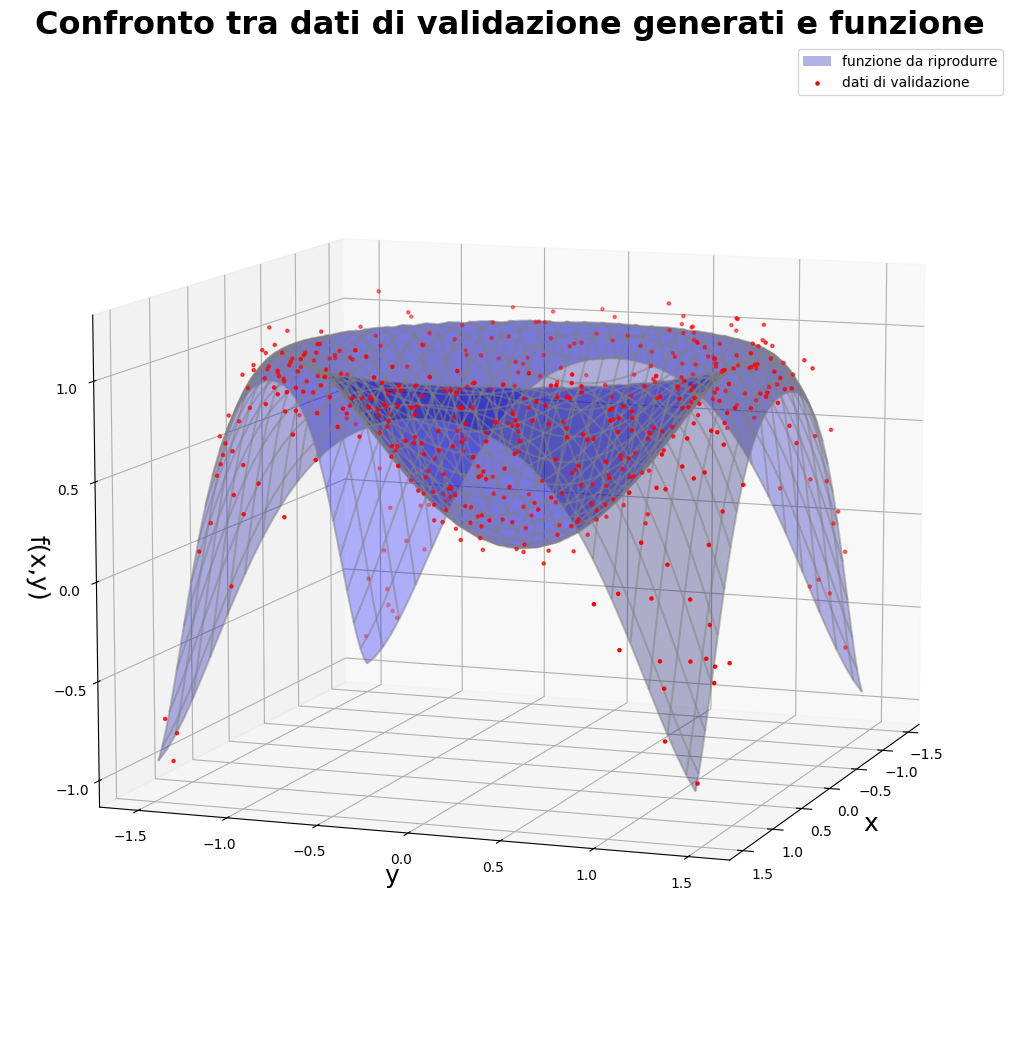

In [3]:
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
fig.add_axes(ax)

x1_true = np.arange(-3./2,3./2, 0.05)
x2_true = np.arange(-3./2,3./2, 0.05)
x1_true_grid, x2_true_grid = np.meshgrid(x1_true,x2_true)
ax.plot_surface(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid), color='b', alpha=0.3, label='funzione da riprodurre')
ax.plot_wireframe(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid),  color='gray', alpha = 0.5)
ax.scatter(x1_valid_s, x2_valid_s, y_valid_s, marker = ".", color = "r", label='dati di validazione')
ax.set_xlabel("x", fontsize = 18)
ax.set_ylabel("y", fontsize = 18)
ax.set_zlabel("f(x,y)", fontsize = 18)
plt.title("Confronto tra dati di validazione generati e funzione", fontsize = 23, fontweight = "bold")
ax.legend()
ax.view_init(10, 20)

plt.show()

Adesso definisco il modello:
- uso una NN sequenziale con diversi layer con un numero di neuroni decrescenti;
- per la funzione di attivazione, utilizzo la tangente iperbolica perchè mi sono accorto che, relu fa fatica a fittare la funzione ai bordi;
- come ottimizzatore uso uno gradiente stocastico;
- infine, utilizzo come funzione di costo il mean squared error

In [4]:
# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

tf.random.set_seed(seed)

model = tf.keras.Sequential()
model.add(Dense(50, input_shape=(2,)))
model.add(Dense(40, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='tanh'))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

2024-06-16 13:22:05.195595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 13:22:05.199488: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 13:22:05.233297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 13:22:05.233339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 13:22:05.234703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [5]:
# get a summary of our composed model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 40)                2040      
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4261 (16.64 KB)
Trainable params: 4261 (16

In [6]:
history_s = model.fit(x_train_s, y=y_train_s, 
          batch_size=int(32), epochs=150,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid_s, y_valid_s))

Epoch 1/150


297/297 [==============================] - 1s 3ms/step - loss: 0.1715 - mse: 0.1715 - val_loss: 0.1546 - val_mse: 0.1546
Epoch 2/150
297/297 [==============================] - 1s 2ms/step - loss: 0.1616 - mse: 0.1616 - val_loss: 0.1551 - val_mse: 0.1551
Epoch 3/150
297/297 [==============================] - 1s 2ms/step - loss: 0.1609 - mse: 0.1609 - val_loss: 0.1550 - val_mse: 0.1550
Epoch 4/150
297/297 [==============================] - 1s 2ms/step - loss: 0.1605 - mse: 0.1605 - val_loss: 0.1552 - val_mse: 0.1552
Epoch 5/150
297/297 [==============================] - 1s 3ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.1539 - val_mse: 0.1539
Epoch 6/150
297/297 [==============================] - 1s 3ms/step - loss: 0.1592 - mse: 0.1592 - val_loss: 0.1532 - val_mse: 0.1532
Epoch 7/150
297/297 [==============================] - 1s 3ms/step - loss: 0.1584 - mse: 0.1584 - val_loss: 0.1523 - val_mse: 0.1523
Epoch 8/150
297/297 [==============================] - 1s 2ms/step - loss: 0.1571

In [7]:
# return weights and biases
model.get_weights()

[array([[-0.37690175, -0.30873206, -0.06495356,  0.21114975,  0.34248573,
          0.03483068,  0.11797391,  0.01887634, -0.01556748, -0.03542254,
          0.33526534, -0.03639341,  0.4574491 , -0.29238674, -0.20859823,
         -0.22860573,  0.26516503, -0.24100874,  0.03330984,  0.116992  ,
         -0.4179047 ,  0.48723543, -0.2756168 , -0.07138624,  0.03727465,
          0.15590915,  0.24099861, -0.2622201 ,  0.19305728, -0.34523585,
          0.08900509,  0.14455652, -0.03170357, -0.41746476, -0.41684827,
          0.3234686 ,  0.21078204,  0.03553773, -0.11451141, -0.05620173,
         -0.06239862, -0.3593152 ,  0.20197736, -0.02569237,  0.19757427,
         -0.18879238, -0.45633483,  0.315656  ,  0.35122964, -0.3871706 ],
        [-0.438909  ,  0.37847915,  0.19911358,  0.18840715, -0.17167708,
          0.42461717, -0.33243182,  0.00137453, -0.24472412,  0.40962166,
         -0.12882882, -0.07972216, -0.18174295,  0.09734646, -0.04260893,
         -0.1586045 ,  0.2863543 , -0

In [8]:
# evaluate model
score_s = model.evaluate(x_valid_s, y_valid_s, batch_size=32, verbose=1)

# print performance
print()
print('Test loss:', score_s[0])
print('Test accuracy:', score_s[1])

16/16 [==============================] - 0s 2ms/step - loss: 0.0114 - mse: 0.0114

Test loss: 0.011363309808075428
Test accuracy: 0.011363309808075428


Come si può vedere la funzione di costo per i dati di test è sempre inferiore a quella dei dati di training; di conseguenza il modello non è in overfitting.

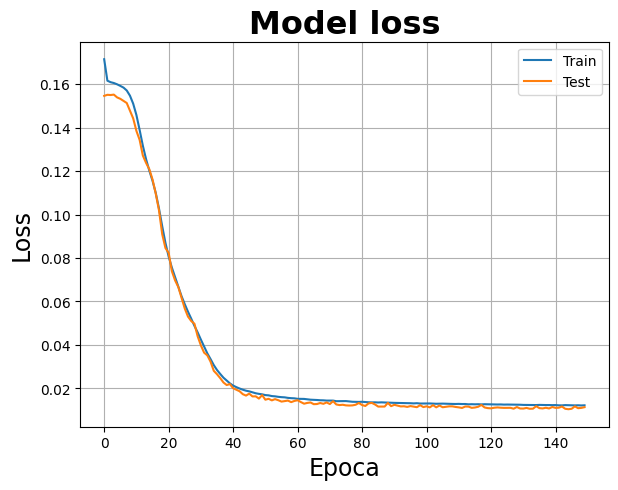

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_s.history['loss'])
plt.plot(history_s.history['val_loss'])
plt.title('Model loss', fontsize = 23, fontweight = "bold")
plt.ylabel('Loss', fontsize = 17)
plt.xlabel('Epoca', fontsize = 17)
plt.legend(['Train', 'Test'], loc='best')
#plt.ylim(0.01, 0.03)
plt.grid()

plt.show()


Il modello sembra fittare piuttosto bene la funizione nella regione centrale. Sembra faticare, come si vede anche nell'esercizio precedente, sui bordi.

113/113 [==============================] - 0s 1ms/step


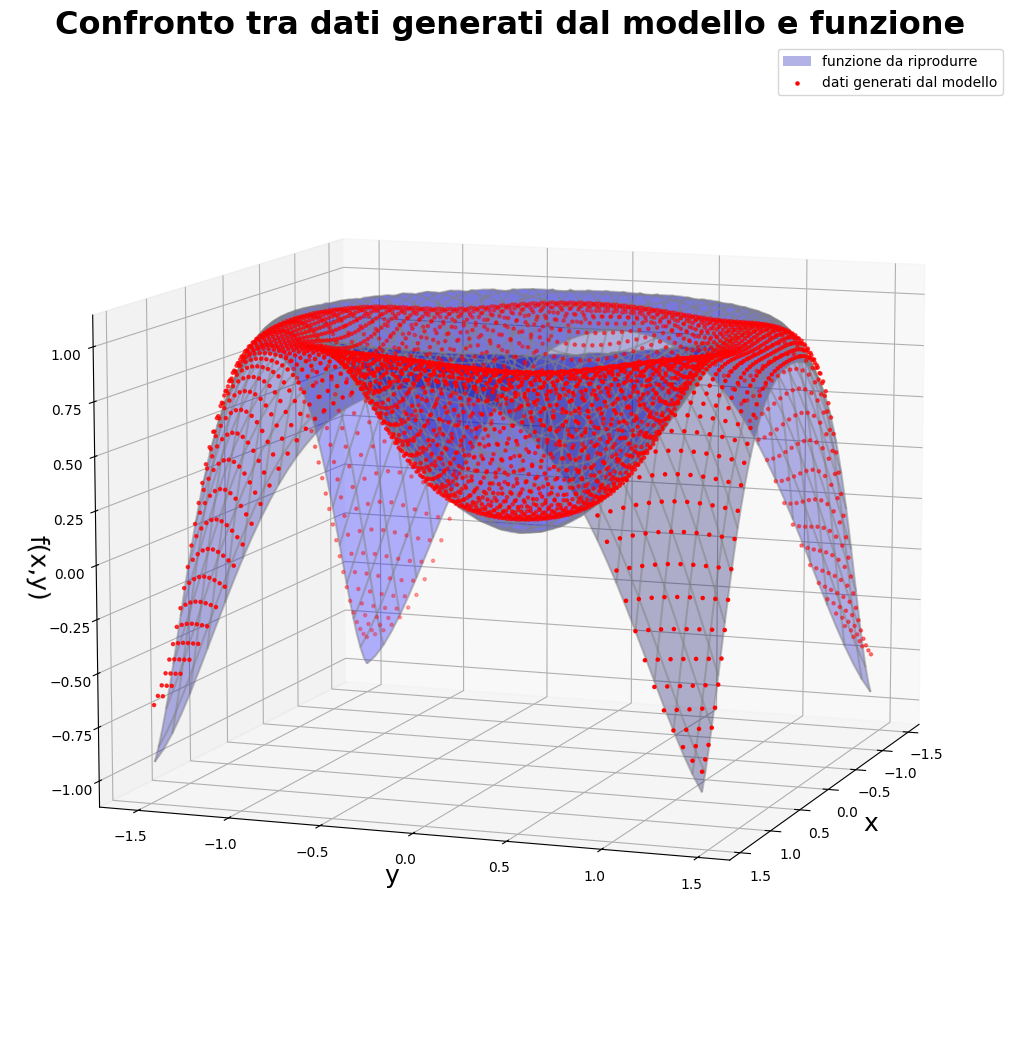

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
fig.add_axes(ax)

x_predicted_s = np.column_stack((x1_true_grid.ravel(), x2_true_grid.ravel()))
y_predicted_s = model.predict(x_predicted_s)

ax.plot_surface(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid), color='b', alpha=0.3, label='funzione da riprodurre')
ax.plot_wireframe(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid),  color='gray', alpha = 0.5)
ax.scatter(x1_true_grid, x2_true_grid, y_predicted_s, marker = ".", color = "r", label='dati generati dal modello')
ax.set_xlabel("x", fontsize = 18)
ax.set_ylabel("y", fontsize = 18)
ax.set_zlabel("f(x,y)", fontsize = 18)
plt.title("Confronto tra dati generati dal modello e funzione", fontsize = 23, fontweight = "bold")
ax.legend()
ax.view_init(10, 20)

plt.show()


113/113 [==============================] - 0s 2ms/step


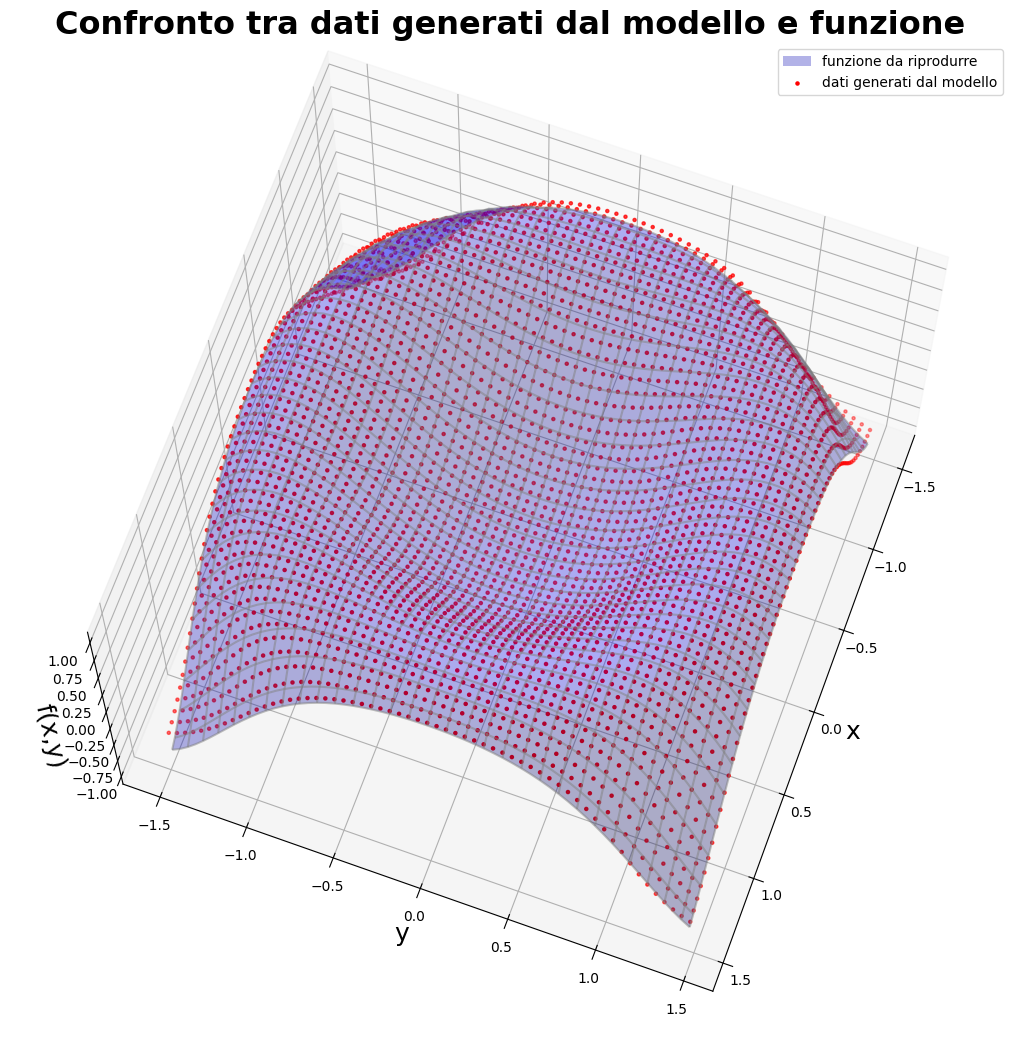

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
fig.add_axes(ax)

x_predicted_s = np.column_stack((x1_true_grid.ravel(), x2_true_grid.ravel()))
y_predicted_s = model.predict(x_predicted_s)

ax.plot_surface(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid), color='b', alpha=0.3, label='funzione da riprodurre')
ax.plot_wireframe(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid),  color='gray', alpha = 0.5)
ax.scatter(x1_true_grid, x2_true_grid, y_predicted_s, marker = ".", color = "r", label='dati generati dal modello')
ax.set_xlabel("x", fontsize = 18)
ax.set_ylabel("y", fontsize = 18)
ax.set_zlabel("f(x,y)", fontsize = 18)
plt.title("Confronto tra dati generati dal modello e funzione", fontsize = 23, fontweight = "bold")
ax.legend()
ax.view_init(70, 20)

plt.show()


Vediamo adesso come si comporta le rete neurale su regioni in cui non è stata allenata.

200/200 [==============================] - 0s 1ms/step


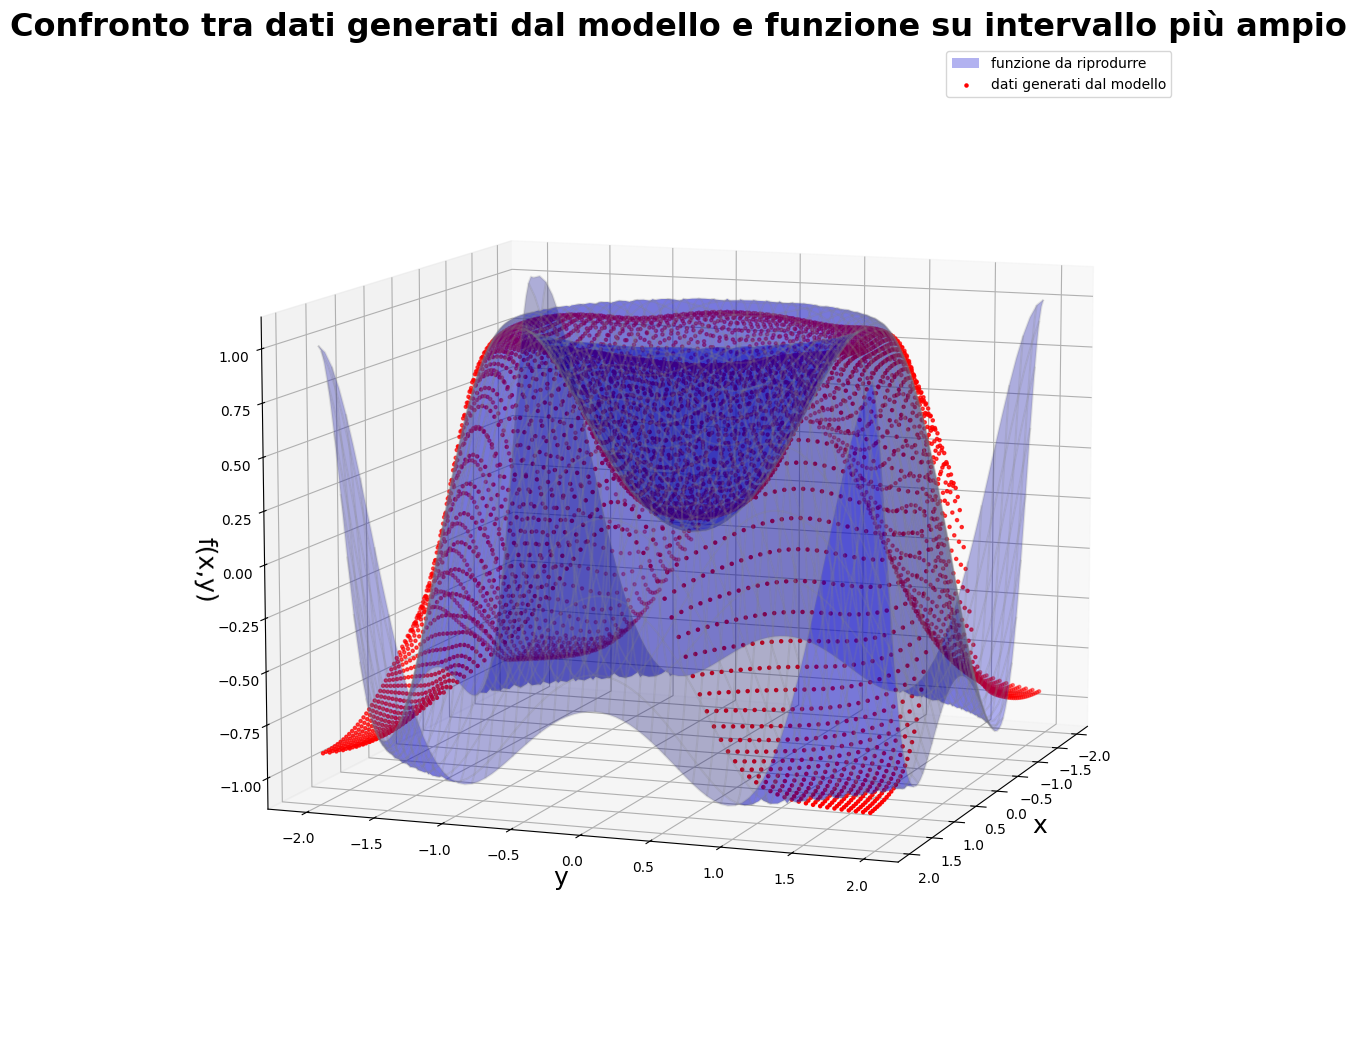

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
fig.add_axes(ax)

x1_true = np.arange(-2,2, 0.05)
x2_true = np.arange(-2,2, 0.05)
x1_true_grid, x2_true_grid = np.meshgrid(x1_true,x2_true)

x_predicted_s = np.column_stack((x1_true_grid.ravel(), x2_true_grid.ravel()))
y_predicted_s = model.predict(x_predicted_s)

ax.plot_surface(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid), color='b', alpha=0.3, label='funzione da riprodurre')
ax.plot_wireframe(x1_true_grid, x2_true_grid, f(x1_true_grid,x2_true_grid),  color='gray', alpha = 0.2)
ax.scatter(x1_true_grid, x2_true_grid, y_predicted_s, marker = ".", color = "r", label='dati generati dal modello')
ax.set_xlabel("x", fontsize = 18)
ax.set_ylabel("y", fontsize = 18)
ax.set_zlabel("f(x,y)", fontsize = 18)
plt.title("Confronto tra dati generati dal modello e funzione su intervallo più ampio", fontsize = 23, fontweight = "bold")
ax.legend()
ax.view_init(10, 20)

plt.show()


Come si vede il modello non fitta bene la funzione fuori dall'intervallo in cui abbiamo allenato; di conseguenza il potere predittivo al di fuori di questo è pressochè nullo. Questo comportamento è stato osservato anche per l'esercizio precedente e per l'esercitazione successiva, perciò bisogna prestare estrema attenzione ai risultati prodotti dalla rete neurale quando proviamo ad estenderne la predittività in regioni non allenate.